<a href="https://colab.research.google.com/github/daisysong76/AI--Machine--learning/blob/main/Melwy_MinLSTM_MinGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CONCLUSION/THEME OF THE PAPER**

In this work, we revisited RNNs from over a decade ago: LSTMs and GRUs. We show that these models are trainable via the parallel scan algorithm by removing their hidden state dependencies from their gates. Simplifying these models further, we removed their constraints on output range and ensured their output was time-independent in scale. These steps result in their minimal versio(minLSTM and minGRU). Empirically, we showed that minLSTM and minGRU (1) address the computational limitations of their traditional counterparts and (2) are as computationally efficient as Mamba, a popular recent state-of-the-art recurrent sequence model, and (3) are competitive in performance with recent sequence models

Read the Paper here:- https://arxiv.org/pdf/2410.01201

# Implementation of MinGRU

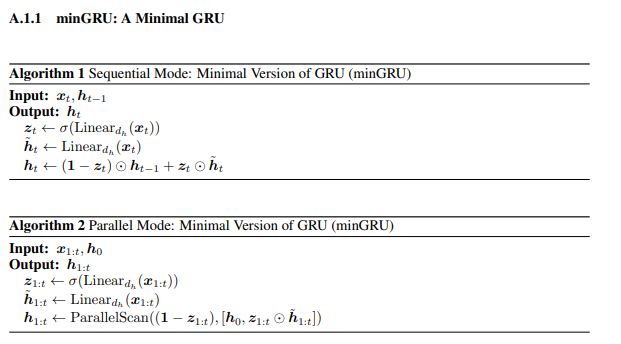

# Sequential Mode

In [ ]:
import numpy as np

class MinGRU:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size

        # Initialize weights
        self.Wz = np.random.randn(input_size, hidden_size) * 0.01  # Update gate weights
        self.Wh = np.random.randn(input_size, hidden_size) * 0.01  # Hidden state weights
        self.Uz = np.random.randn(hidden_size, hidden_size) * 0.01  # Update gate recurrent weights
        self.Uh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden state recurrent weights

        # Initialize biases
        self.bz = np.zeros((1, hidden_size))
        self.bh = np.zeros((1, hidden_size))

    def forward(self, x_t, h_prev):
        # Update gate
        z_t = self.sigmoid(np.dot(x_t, self.Wz) + np.dot(h_prev, self.Uz) + self.bz)

        # Candidate hidden state
        h_tilde = np.tanh(np.dot(x_t, self.Wh) + np.dot(h_prev, self.Uh) + self.bh)

        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_tilde

        return h_t

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Example usage
input_size = 3   # Size of input vector
hidden_size = 2  # Size of hidden state

min_gru = MinGRU(input_size, hidden_size)
h_prev = np.zeros((1, hidden_size))  # Initial hidden state
x_t = np.random.randn(5, input_size)  # Current input

# Forward pass
h_t = min_gru.forward(x_t, h_prev)
print("New hidden state:", h_t)

New hidden state: [[-0.00174463  0.00218964]
 [-0.00058718 -0.00030642]
 [-0.01066375  0.01094028]
 [-0.00412051  0.00601153]
 [-0.01121788  0.00778507]]


# Parallel Mode

In [ ]:
import numpy as np

class MinGRU:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size

        # Initialize weights
        self.Wz = np.random.randn(input_size, hidden_size) * 0.01  # Update gate weights
        self.Wh = np.random.randn(input_size, hidden_size) * 0.01  # Hidden state weights
        self.Uz = np.random.randn(hidden_size, hidden_size) * 0.01  # Update gate recurrent weights
        self.Uh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden state recurrent weights

        # Initialize biases
        self.bz = np.zeros((1, hidden_size))
        self.bh = np.zeros((1, hidden_size))

    def forward(self, x_seq):
        # Initialize hidden states
        h_states = np.zeros((x_seq.shape[0], self.hidden_size))

        for t in range(x_seq.shape[0]):
            if t == 0:
                h_prev = np.zeros((1, self.hidden_size))  # Initial hidden state
            else:
                h_prev = h_states[t-1:t]  # Previous hidden state

            # Update gate
            z_t = self.sigmoid(np.dot(x_seq[t], self.Wz) + np.dot(h_prev, self.Uz) + self.bz)

            # Candidate hidden state
            h_tilde = np.tanh(np.dot(x_seq[t], self.Wh) + np.dot(h_prev, self.Uh) + self.bh)

            # New hidden state
            h_states[t] = (1 - z_t) * h_prev + z_t * h_tilde

        return h_states

    def parallel_scan(self, x_seq):
        n = x_seq.shape[0]
        h_states = np.zeros((n, self.hidden_size))

        # Step 1: Calculate hidden states in parallel
        for t in range(n):
            if t == 0:
                h_states[t] = np.zeros((self.hidden_size,))  # Initial hidden state
            else:
                h_prev = h_states[t-1]  # Previous hidden state

            z_t = self.sigmoid(np.dot(x_seq[t], self.Wz) + np.dot(h_states[t-1], self.Uz) + self.bz)
            h_tilde = np.tanh(np.dot(x_seq[t], self.Wh) + np.dot(h_states[t-1], self.Uh) + self.bh)
            h_states[t] = (1 - z_t) * h_states[t-1] + z_t * h_tilde

        return h_states

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Example usage
input_size = 3   # Size of input vector
hidden_size = 2  # Size of hidden state

min_gru = MinGRU(input_size, hidden_size)
x_seq = np.random.randn(5, input_size)  # Sequence of inputs with 5 time steps

# Forward pass with parallel scan
h_states = min_gru.parallel_scan(x_seq)
print("Hidden states:\n", h_states)

Hidden states:
 [[ 0.00691047  0.00180514]
 [ 0.01001159  0.00910741]
 [ 0.00542941  0.00028671]
 [ 0.00053134  0.0034069 ]
 [-0.00114171  0.00567375]]


# BabyLM from MinGRU

In [ ]:
import numpy as np

# Softmax function (used in both BabyLM and text generation)
def softmax(x, axis=None):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

class BabyLM:
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        self.hidden_size = hidden_size

        # Token embedding
        self.embeddings = np.random.randn(vocab_size, embedding_dim) * 0.01

        # GRU weights
        self.Wz = np.random.randn(embedding_dim, hidden_size) * 0.01
        self.Wh = np.random.randn(embedding_dim, hidden_size) * 0.01
        self.Uz = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Uh = np.random.randn(hidden_size, hidden_size) * 0.01

        # Biases
        self.bz = np.zeros((1, hidden_size))
        self.bh = np.zeros((1, hidden_size))

        # Output layer weights
        self.Wo = np.random.randn(hidden_size, vocab_size) * 0.01
        self.bo = np.zeros((1, vocab_size))

    def forward(self, input_seq):
        # Convert input token indices to embeddings
        x_seq = self.embeddings[input_seq]

        # Initialize hidden states
        h_states = np.zeros((x_seq.shape[0], self.hidden_size))

        for t in range(x_seq.shape[0]):
            if t == 0:
                h_prev = np.zeros((1, self.hidden_size))  # Initial hidden state
            else:
                h_prev = h_states[t-1:t]  # Previous hidden state

            # Update gate
            z_t = self.sigmoid(np.dot(x_seq[t], self.Wz) + np.dot(h_prev, self.Uz) + self.bz)

            # Candidate hidden state
            h_tilde = np.tanh(np.dot(x_seq[t], self.Wh) + np.dot(h_prev, self.Uh) + self.bh)

            # New hidden state
            h_states[t] = (1 - z_t) * h_prev + z_t * h_tilde

        # Output predictions for each time step
        logits = np.dot(h_states, self.Wo) + self.bo
        self.h_states = h_states
        return logits

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [ ]:
vocab = ["I", "love", "to", "code", "explore", "learn", "is", "fun", "the", "world", "new", "things", "exciting", "end", "Coding", "Exploring", "Learning"]
vocab_size = len(vocab)
embedding_dim = 16384
hidden_size = 8

# Instantiate BabyLM model
model = BabyLM(vocab_size, embedding_dim, hidden_size)

# Prepare training data
sentences = [
    "I love to code",
    "I love to explore",
    "I love to learn",
    "Coding is fun",
    "Exploring the world",
    "Learning new things is exciting",
]

# Word-to-index mapping
word_to_index = {word: i for i, word in enumerate(vocab)}

# Training data as sequences of indices
training_data = []
for sentence in sentences:
    indices = [word_to_index[word] for word in sentence.split()] + [word_to_index["end"]]
    training_data.append(indices)

# Simple training function
def train_model(model, training_data, epochs=100, learning_rate=2e-5):
    for epoch in range(epochs):
        total_loss = 0
        for sequence in training_data:
            input_seq = sequence[:-1]  # All words except the last one
            target_seq = sequence[1:]  # All words except the first one
            input_seq_np = np.array(input_seq)

            # Forward pass to get logits
            logits = model.forward(input_seq_np)

            # Calculate loss
            batch_size, vocab_size = logits.shape
            log_probs = np.log(softmax(logits, axis=1))
            loss = -np.sum(log_probs[np.arange(batch_size), target_seq]) / batch_size
            total_loss += loss

            # Backpropagation through time (BPTT)
            dL_dlogits = softmax(logits)  # Start with softmax probabilities
            dL_dlogits[np.arange(batch_size), target_seq] -= 1  # Subtract 1 for correct class
            dL_dlogits /= batch_size  # Average over the batch size

            # Gradients for output layer weights
            dWo = np.dot(model.h_states.T, dL_dlogits)  # hidden states x dL/dlogits
            dbo = np.sum(dL_dlogits, axis=0, keepdims=True)

            # Initialize gradients for GRU parameters
            dWz, dWh, dUz, dUh = np.zeros_like(model.Wz), np.zeros_like(model.Wh), np.zeros_like(model.Uz), np.zeros_like(model.Uh)
            dbz, dbh = np.zeros_like(model.bz), np.zeros_like(model.bh)
            dh_next = np.zeros((1, model.hidden_size))  # Next hidden state gradient

            # BPTT for each time step (reverse order)
            for t in reversed(range(len(input_seq_np))):
                # Gradients of output w.r.t hidden state
                dh = np.dot(dL_dlogits[t], model.Wo.T) + dh_next

                # GRU gradients
                z_t = model.sigmoid(np.dot(model.embeddings[input_seq_np[t]], model.Wz) + np.dot(model.h_states[t-1], model.Uz) + model.bz)
                h_tilde = np.tanh(np.dot(model.embeddings[input_seq_np[t]], model.Wh) + np.dot(model.h_states[t-1], model.Uh) + model.bh)
                dz = dh * (h_tilde - model.h_states[t-1]) * z_t * (1 - z_t)
                dh_tilde = dh * z_t * (1 - h_tilde ** 2)

                # Accumulate gradients
                dWz += np.dot(model.embeddings[input_seq_np[t]].reshape(-1, 1), dz)
                dUz += np.dot(model.h_states[t-1].reshape(-1,1), dz)
                dbz += dz
                dWh += np.dot(model.embeddings[input_seq_np[t]].reshape(-1,1), dh_tilde)
                dUh += np.dot(model.h_states[t-1].reshape(-1,1), dh_tilde)
                dbh += dh_tilde

                # Gradient for next hidden state
                dh_next = np.dot(dz, model.Uz.T) + np.dot(dh_tilde, model.Uh.T)

            # Update weights with gradient descent
            model.Wo -= learning_rate * dWo
            model.bo -= learning_rate * dbo
            model.Wz -= learning_rate * dWz
            model.Wh -= learning_rate * dWh
            model.Uz -= learning_rate * dUz
            model.Uh -= learning_rate * dUh
            model.bz -= learning_rate * dbz
            model.bh -= learning_rate * dbh

        # Print average loss per epoch for monitoring
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(training_data)}")

train_model(model, training_data)

# Text generation with temperature
def generate_text_with_temperature(model, input_sequence, max_length=10, temperature=1.0):
    generated_sequence = input_sequence.copy()

    for _ in range(max_length):
        input_seq_np = np.array(generated_sequence)
        logits = model.forward(input_seq_np)
        last_logits = logits[-1]

        # Temperature scaling
        scaled_logits = last_logits / temperature
        probabilities = softmax(scaled_logits)

        # Sample next word
        next_word_index = np.random.choice(np.arange(vocab_size), p=probabilities)

        if next_word_index == word_to_index["end"]:
            break

        generated_sequence.append(next_word_index)

    return generated_sequence

# Generate multiple text sequences
num_generations = 10
input_sequence = [word_to_index["I"], word_to_index["love"], word_to_index["to"]]
all_generated_sequences = []

for _ in range(num_generations):
    generated_indices = generate_text_with_temperature(model, input_sequence, temperature=0.5)
    all_generated_sequences.append([vocab[i] for i in generated_indices])

# Output generated sequences
for i, seq in enumerate(all_generated_sequences):
    print(f"Generated Sequence {i + 1}: {' '.join(seq)}")

Epoch 1, Loss: 2.8332308334407688
Epoch 2, Loss: 2.833222339528637
Epoch 3, Loss: 2.833213845692604
Epoch 4, Loss: 2.8332053519326714
Epoch 5, Loss: 2.8331968582488387
Epoch 6, Loss: 2.8331883646411087
Epoch 7, Loss: 2.8331798711094813
Epoch 8, Loss: 2.833171377653956
Epoch 9, Loss: 2.8331628842745356
Epoch 10, Loss: 2.83315439097122
Epoch 11, Loss: 2.8331458977440094
Epoch 12, Loss: 2.833137404592905
Epoch 13, Loss: 2.833128911517908
Epoch 14, Loss: 2.8331204185190195
Epoch 15, Loss: 2.833111925596239
Epoch 16, Loss: 2.8331034327495686
Epoch 17, Loss: 2.8330949399790075
Epoch 18, Loss: 2.833086447284559
Epoch 19, Loss: 2.8330779546662206
Epoch 20, Loss: 2.833069462123996
Epoch 21, Loss: 2.8330609696578843
Epoch 22, Loss: 2.8330524772678873
Epoch 23, Loss: 2.833043984954005
Epoch 24, Loss: 2.8330354927162382
Epoch 25, Loss: 2.833027000554589
Epoch 26, Loss: 2.8330185084690562
Epoch 27, Loss: 2.833010016459642
Epoch 28, Loss: 2.833001524526346
Epoch 29, Loss: 2.8329930326691706
Epoch 30

# Observation

1. decrease in learning rates is helping building meaningful sentences.
2. Increase in epochs is increasing the verbosity of the model.
3. There is no change in the losses over all training.
4. Increasing the temperature is giving good results.
5. Increasing the embed size is being helpful.

# Implementation with MinLSTM

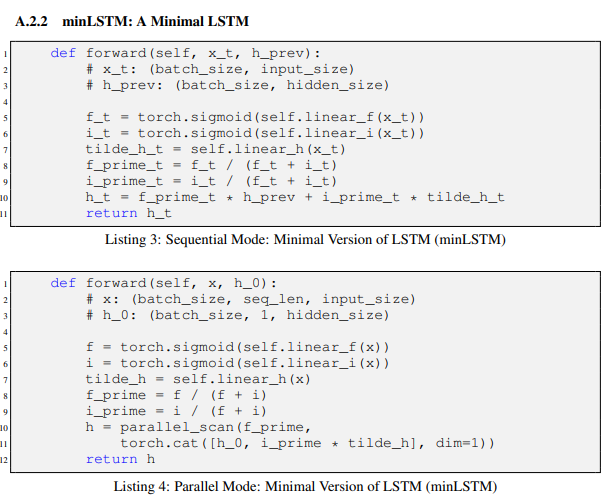

# Sequential Mode

In [ ]:
import numpy as np

class MinLSTM:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size

        # Initialize weights for gates
        self.Wf = np.random.randn(input_size, hidden_size) * 0.01  # Forget gate weights
        self.Wi = np.random.randn(input_size, hidden_size) * 0.01  # Input gate weights
        self.Wc = np.random.randn(input_size, hidden_size) * 0.01  # Cell candidate weights
        self.Wo = np.random.randn(input_size, hidden_size) * 0.01  # Output gate weights

        self.Uf = np.random.randn(hidden_size, hidden_size) * 0.01  # Forget gate recurrent weights
        self.Ui = np.random.randn(hidden_size, hidden_size) * 0.01  # Input gate recurrent weights
        self.Uc = np.random.randn(hidden_size, hidden_size) * 0.01  # Cell candidate recurrent weights
        self.Uo = np.random.randn(hidden_size, hidden_size) * 0.01  # Output gate recurrent weights

        # Initialize biases
        self.bf = np.zeros((1, hidden_size))
        self.bi = np.zeros((1, hidden_size))
        self.bc = np.zeros((1, hidden_size))
        self.bo = np.zeros((1, hidden_size))

    def forward(self, x_t, h_prev, c_prev):
        # Forget gate
        f_t = self.sigmoid(np.dot(x_t, self.Wf) + np.dot(h_prev, self.Uf) + self.bf)
        # Input gate
        i_t = self.sigmoid(np.dot(x_t, self.Wi) + np.dot(h_prev, self.Ui) + self.bi)
        # Cell candidate
        c_tilde = np.tanh(np.dot(x_t, self.Wc) + np.dot(h_prev, self.Uc) + self.bc)
        # New cell state
        c_t = f_t * c_prev + i_t * c_tilde
        # Output gate
        o_t = self.sigmoid(np.dot(x_t, self.Wo) + np.dot(h_prev, self.Uo) + self.bo)
        # New hidden state
        h_t = o_t * np.tanh(c_t)

        return h_t, c_t

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Example usage
input_size = 3   # Size of input vector
hidden_size = 2  # Size of hidden state

min_lstm = MinLSTM(input_size, hidden_size)
h_prev = np.zeros((1, hidden_size))  # Initial hidden state
c_prev = np.zeros((1, hidden_size))  # Initial cell state
x_t = np.random.randn(1, input_size)  # Current input

# Forward pass
h_t, c_t = min_lstm.forward(x_t, h_prev, c_prev)
print("New hidden state:", h_t)
print("New cell state:", c_t)

New hidden state: [[0.00211566 0.00616015]]
New cell state: [[0.00425515 0.01245095]]


# Parallel Mode

In [ ]:
import numpy as np

class MinLSTM:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size

        # Initialize weights
        self.Wf = np.random.randn(input_size, hidden_size) * 0.01  # Forget gate weights
        self.Wi = np.random.randn(input_size, hidden_size) * 0.01  # Input gate weights
        self.Wc = np.random.randn(input_size, hidden_size) * 0.01  # Cell state weights
        self.Wo = np.random.randn(input_size, hidden_size) * 0.01  # Output gate weights

        self.Uf = np.random.randn(hidden_size, hidden_size) * 0.01  # Forget gate recurrent weights
        self.Ui = np.random.randn(hidden_size, hidden_size) * 0.01  # Input gate recurrent weights
        self.Uc = np.random.randn(hidden_size, hidden_size) * 0.01  # Cell state recurrent weights
        self.Uo = np.random.randn(hidden_size, hidden_size) * 0.01  # Output gate recurrent weights

        # Initialize biases
        self.bf = np.zeros((1, hidden_size))
        self.bi = np.zeros((1, hidden_size))
        self.bc = np.zeros((1, hidden_size))
        self.bo = np.zeros((1, hidden_size))

    def forward(self, x_seq):
        n = x_seq.shape[0]
        h_states = np.zeros((n, self.hidden_size))
        c_states = np.zeros((n, self.hidden_size))

        for t in range(n):
            if t == 0:
                h_prev = np.zeros((1, self.hidden_size))  # Initial hidden state
                c_prev = np.zeros((1, self.hidden_size))  # Initial cell state
            else:
                h_prev = h_states[t-1:t]  # Previous hidden state
                c_prev = c_states[t-1:t]  # Previous cell state

            # Forget gate
            f_t = self.sigmoid(np.dot(x_seq[t], self.Wf) + np.dot(h_prev, self.Uf) + self.bf)
            # Input gate
            i_t = self.sigmoid(np.dot(x_seq[t], self.Wi) + np.dot(h_prev, self.Ui) + self.bi)
            # Candidate cell state
            c_tilde = np.tanh(np.dot(x_seq[t], self.Wc) + np.dot(h_prev, self.Uc) + self.bc)
            # Update cell state
            c_t = f_t * c_prev + i_t * c_tilde
            # Output gate
            o_t = self.sigmoid(np.dot(x_seq[t], self.Wo) + np.dot(h_prev, self.Uo) + self.bo)
            # New hidden state
            h_states[t] = o_t * np.tanh(c_t)
            c_states[t] = c_t

        return h_states, c_states

    def parallel_scan(self, x_seq):
        n = x_seq.shape[0]
        h_states = np.zeros((n, self.hidden_size))
        c_states = np.zeros((n, self.hidden_size))

        for t in range(n):
            if t == 0:
                h_prev = np.zeros((self.hidden_size,))  # Initial hidden state
                c_prev = np.zeros((self.hidden_size,))  # Initial cell state
            else:
                h_prev = h_states[t-1]  # Previous hidden state
                c_prev = c_states[t-1]  # Previous cell state

            f_t = self.sigmoid(np.dot(x_seq[t], self.Wf) + np.dot(h_prev, self.Uf) + self.bf)
            i_t = self.sigmoid(np.dot(x_seq[t], self.Wi) + np.dot(h_prev, self.Ui) + self.bi)
            c_tilde = np.tanh(np.dot(x_seq[t], self.Wc) + np.dot(h_prev, self.Uc) + self.bc)
            c_t = f_t * c_prev + i_t * c_tilde
            o_t = self.sigmoid(np.dot(x_seq[t], self.Wo) + np.dot(h_prev, self.Uo) + self.bo)
            h_states[t] = o_t * np.tanh(c_t)
            c_states[t] = c_t

        return h_states, c_states

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Example usage
input_size = 3   # Size of input vector
hidden_size = 2  # Size of hidden state

min_lstm = MinLSTM(input_size, hidden_size)
x_seq = np.random.randn(5, input_size)  # Sequence of inputs with 5 time steps

# Forward pass with parallel scan
h_states, c_states = min_lstm.parallel_scan(x_seq)
print("Hidden states:\n", h_states)
print("Cell states:\n", c_states)

# BabyLM with MinLSTM

# **FUTURE WORK**

Building Transformers with RNNs
While traditional transformers do not use RNNs, you could create a hybrid model that combines aspects of both:

1. RNN as an Encoder/Decoder: You can use RNNs (like LSTMs or GRUs) as the encoder and decoder components of a transformer model. For instance, the RNN could encode input sequences while a transformer architecture handles attention and processing.


2. Attention Mechanism in RNNs: You can implement an attention mechanism within an RNN. This allows the RNN to focus on different parts of the input sequence, similar to how transformers operate. This approach can help the RNN better capture dependencies over long sequences.

3. Attention-based RNNs: Models like Attention RNNs and Seq2Seq with Attention leverage attention mechanisms within the RNN framework, enhancing their ability to handle long-range dependencies.